In [14]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

from src.VAE import LinearVAE

In [40]:
encoder1 = nn.Sequential(nn.Linear(28 * 28, 512),
                         nn.ReLU())
decoder1 = nn.Sequential(nn.Linear(512, 28 * 28),
                         nn.Sigmoid())
encoder2 = nn.Sequential(nn.Linear(28 * 28, 512),
                         nn.ReLU(),
                         nn.Linear(512, 256),
                         nn.ReLU())
decoder2 = nn.Sequential(nn.Linear(256, 512),
                         nn.ReLU(),
                         nn.Linear(512, 28 * 28),
                         nn.Sigmoid())
vae = LinearVAE(encoder1, decoder1, 512, 512)

In [41]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [42]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=30000)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)
model = vae.to('cuda')
optimizer = optim.Adadelta(model.parameters(), lr=1e-1)
scheduler = StepLR(optimizer, step_size=10, gamma=0.95)

In [43]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to('cuda').view(-1, 28 * 28)
        optimizer.zero_grad()
        output, mu, log_var = model(data)
        recon_loss = BCE(output, data)
        loss = 10 * KLD(mu, log_var) + recon_loss
        loss.backward()
        optimizer.step()
        if epoch % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                       100. * (batch_idx + 1) / len(train_loader), loss.item(), recon_loss.item()))

In [44]:
for epoch in range(1, 100):
    train(model, train_loader, optimizer, epoch)
    scheduler.step()

Train Epoch: 5 [30000/60000 (50%)]	Total Loss: 0.768840	Reconstruction Loss: 0.732361
Train Epoch: 5 [60000/60000 (100%)]	Total Loss: 0.766883	Reconstruction Loss: 0.732273
Train Epoch: 10 [30000/60000 (50%)]	Total Loss: 0.757881	Reconstruction Loss: 0.731579
Train Epoch: 10 [60000/60000 (100%)]	Total Loss: 0.756980	Reconstruction Loss: 0.731559
Train Epoch: 15 [30000/60000 (50%)]	Total Loss: 0.752481	Reconstruction Loss: 0.731258
Train Epoch: 15 [60000/60000 (100%)]	Total Loss: 0.751939	Reconstruction Loss: 0.731212
Train Epoch: 20 [30000/60000 (50%)]	Total Loss: 0.749001	Reconstruction Loss: 0.730959
Train Epoch: 20 [60000/60000 (100%)]	Total Loss: 0.748600	Reconstruction Loss: 0.730881
Train Epoch: 25 [30000/60000 (50%)]	Total Loss: 0.746513	Reconstruction Loss: 0.730628
Train Epoch: 25 [60000/60000 (100%)]	Total Loss: 0.746220	Reconstruction Loss: 0.730551


KeyboardInterrupt: 

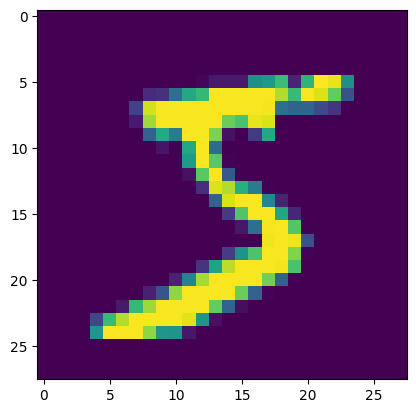

In [19]:
for i in train_loader:
    plt.imshow(i[0][0][0])
    break